# PENARIKAN DATASET DARI KAGGLE

In [255]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"lizapuspitap","key":"80d2683df957b3a46f4f90f1ceb231e1"}'}

In [256]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [257]:
!kaggle datasets download -d hellbuoy/online-retail-customer-clustering

online-retail-customer-clustering.zip: Skipping, found more recently modified local copy (use --force to force download)


In [258]:
!mkdir online-retail-customer-clustering
!unzip online-retail-customer-clustering.zip -d online-retail-customer-clustering
!ls online-retail-customer-clustering

mkdir: cannot create directory ‘online-retail-customer-clustering’: File exists
Archive:  online-retail-customer-clustering.zip
replace online-retail-customer-clustering/OnlineRetail.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
OnlineRetail.csv


# DATA UNDERSTANDING

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [310]:
df = pd.read_csv('/content/online-retail-customer-clustering/OnlineRetail.csv', encoding='latin1')

In [311]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [313]:
df.shape

(541909, 8)

In [314]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# DATA PREPARATION

In [315]:
df = df.dropna()

In [316]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [317]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [318]:
df['CustomerID'] = df['CustomerID'].astype(str)

In [319]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [320]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [321]:
# kolom baru total spent customer
df['Amount']= df['Quantity'] * df['UnitPrice']

amount = df['Amount'].groupby(df['CustomerID']).sum()
amount = pd.DataFrame(amount).reset_index()
amount.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [322]:
# kolom baru total invoce/total berapa kali customer belanja
Freq = df.groupby('CustomerID', as_index=False)['InvoiceNo'].count()
Freq.columns = ['CustomerID', 'Frequency']
Freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [323]:
df['diff_date'] = max(df['InvoiceDate']) - df['InvoiceDate']
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff_date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00


In [324]:
# Hitung tanggal transaksi terakhir
# Untuk mendapatkan informasi terbaru dari pelanggan

last_trans = df.groupby('CustomerID')['diff_date'].min()
last_trans = last_trans.reset_index()
last_trans.head()

,CustomerID,diff_date
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [325]:
# convert jadi days
last_trans['diff_date'] = last_trans['diff_date'].dt.days
last_trans.columns = ['CustomerID', 'Recency']
last_trans.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [326]:
# Combine R, F, M
df2 = pd.concat((last_trans['Recency'], Freq['Frequency'], amount['Amount']), axis=1)

In [327]:
df2.head()

,Recency,Frequency,Amount
0,325,2,0.00
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55
4,309,17,334.40


In [328]:
df2 = df2[df2.Amount > 0]

In [329]:
# Scaling Atribut
from sklearn.preprocessing import StandardScaler

# simpan dataframe asli
keys = df2.keys()
df2_unscaled = df2

# Scale df2
scaler = StandardScaler()
df2 = scaler.fit_transform(df2)
df2 = pd.DataFrame(df2, columns=keys)
print(df2.head())

    Recency  Frequency    Amount
0 -0.891260   0.376466  0.288849
1 -0.154795  -0.269954 -0.015280
2 -0.719755  -0.090155 -0.020084
3  2.216019  -0.329887 -0.192332
4 -0.548249   0.004025 -0.045760


In [330]:
# Menghapus nilai di luar rata-rata +/- 3 scale value
for key in df2.keys():
    mean = np.mean(df2[key])
    std = np.std(df2[key])
    df2 = df2[np.abs(df2[key] - mean) / std <= 3]

# MODELING

In [332]:
# Gambar kurva siku untuk menemukan nilai K yang optimal
# 2 <= i <= 10
inertia = {}
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, max_iter=1000, n_init=10)
    kmeans.fit(df2)
    inertia[i] = kmeans.inertia_

for k, v in inertia.items():
    print(str(k), ': ', str(v))

2 :  1921.0109183615905
3 :  1296.5577537150941
4 :  855.5370471765843
5 :  680.949587580124
6 :  552.3906975164389
7 :  466.2209700198107
8 :  416.6718544850929
9 :  372.0942516349042
10 :  330.21304880271134


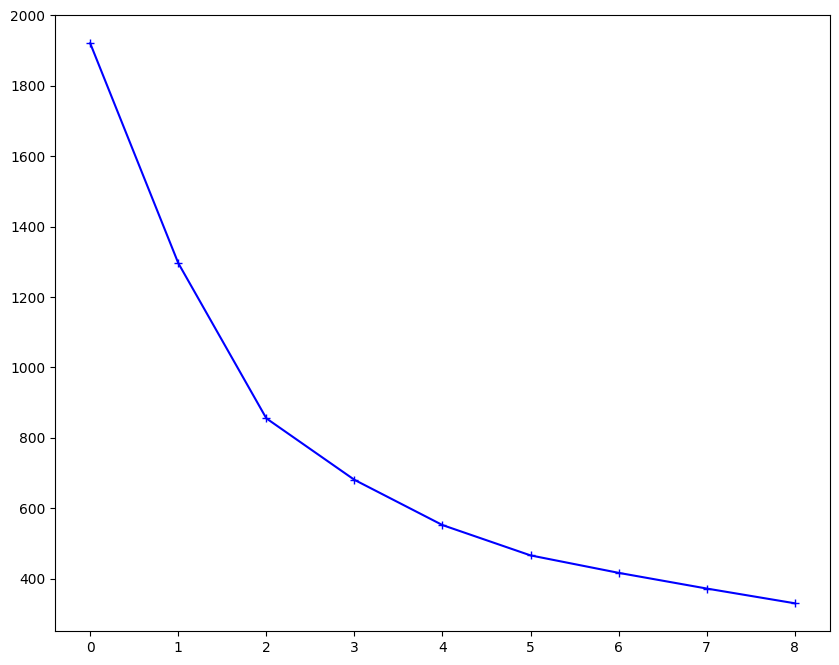

In [333]:
# Plot for each K value
plt.subplots()
plt.plot(list(inertia.values()), 'b+-')
plt.show()

In [336]:
# # Silhouette analysis
from sklearn.metrics import silhouette_score

for num_clusters in range(2,10):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000, n_init=10)
    kmeans.fit(df2)
    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(df2, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1:.4f}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6247
For n_clusters=3, the silhouette score is 0.5459
For n_clusters=4, the silhouette score is 0.5235
For n_clusters=5, the silhouette score is 0.4270
For n_clusters=6, the silhouette score is 0.4292
For n_clusters=7, the silhouette score is 0.4190
For n_clusters=8, the silhouette score is 0.4033
For n_clusters=9, the silhouette score is 0.4057


In [341]:
n_clust = 3
kmeans = KMeans(n_clusters=n_clust, max_iter=1000, n_init=10)
kmeans.fit(df2)
print(kmeans.labels_)

[2 1 1 ... 1 2 1]


In [343]:
# Assign label
df2['Labels'] = kmeans.labels_
df2.head()

,Recency,Frequency,Amount,Labels
0,-0.891260,0.376466,0.288849,2
1,-0.154795,-0.269954,-0.015280,1
2,-0.719755,-0.090155,-0.020084,1
3,2.216019,-0.329887,-0.192332,0
4,-0.548249,0.004025,-0.045760,1


# EVALUATION

In [345]:
df2.head()

,Recency,Frequency,Amount,Labels
0,-0.891260,0.376466,0.288849,2
1,-0.154795,-0.269954,-0.015280,1
2,-0.719755,-0.090155,-0.020084,1
3,2.216019,-0.329887,-0.192332,0
4,-0.548249,0.004025,-0.045760,1


<Axes: xlabel='Amount', ylabel='Recency'>

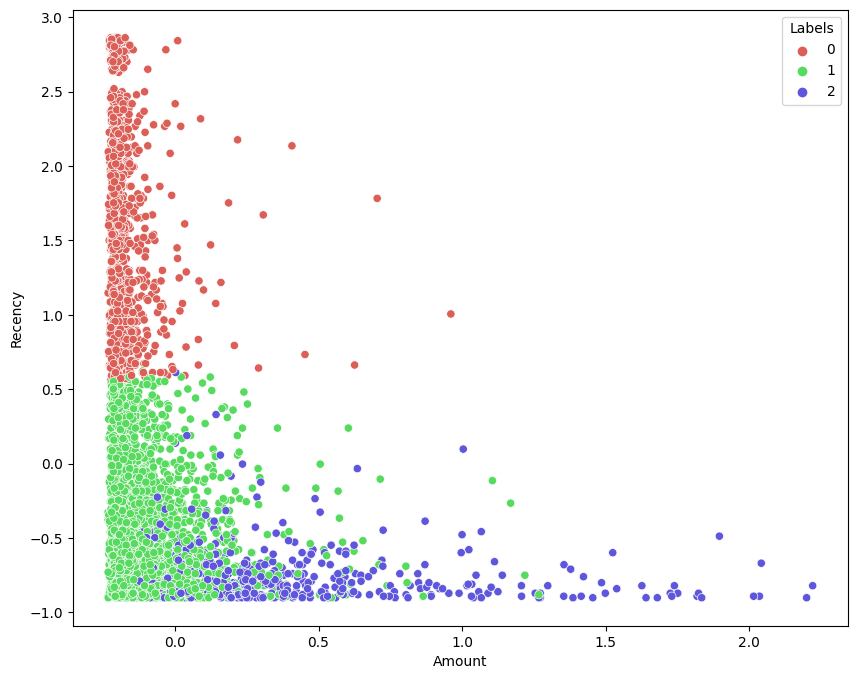

In [346]:
sns.scatterplot(x=df2['Amount'], y=df2['Recency'], hue=df2['Labels'], palette=sns.color_palette('hls', n_colors=n_clust))

<Axes: xlabel='Amount', ylabel='Frequency'>

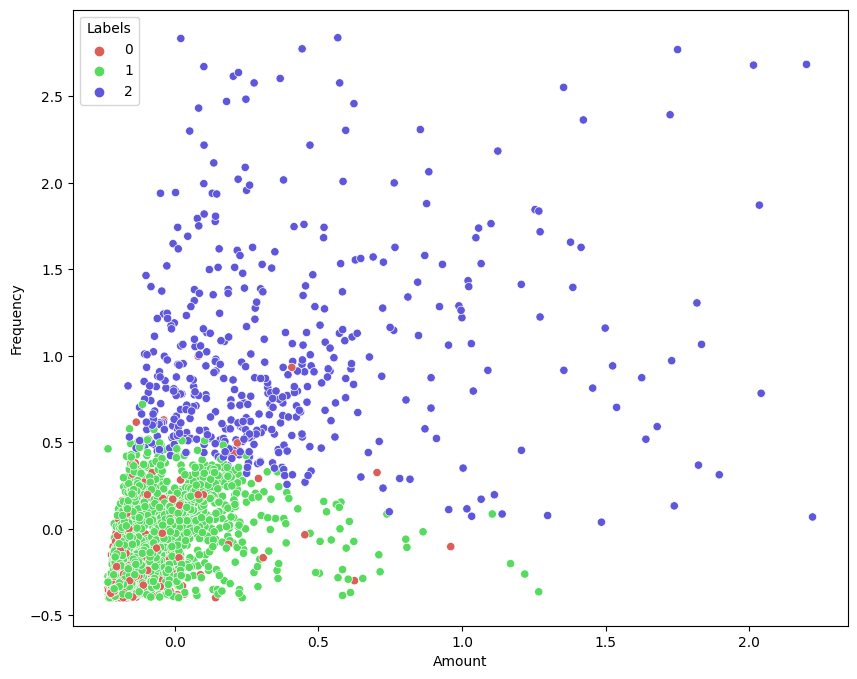

In [347]:
sns.scatterplot(x=df2['Amount'], y=df2['Frequency'], hue=df2['Labels'], palette=sns.color_palette('hls', n_colors=n_clust))

<Axes: xlabel='Frequency', ylabel='Recency'>

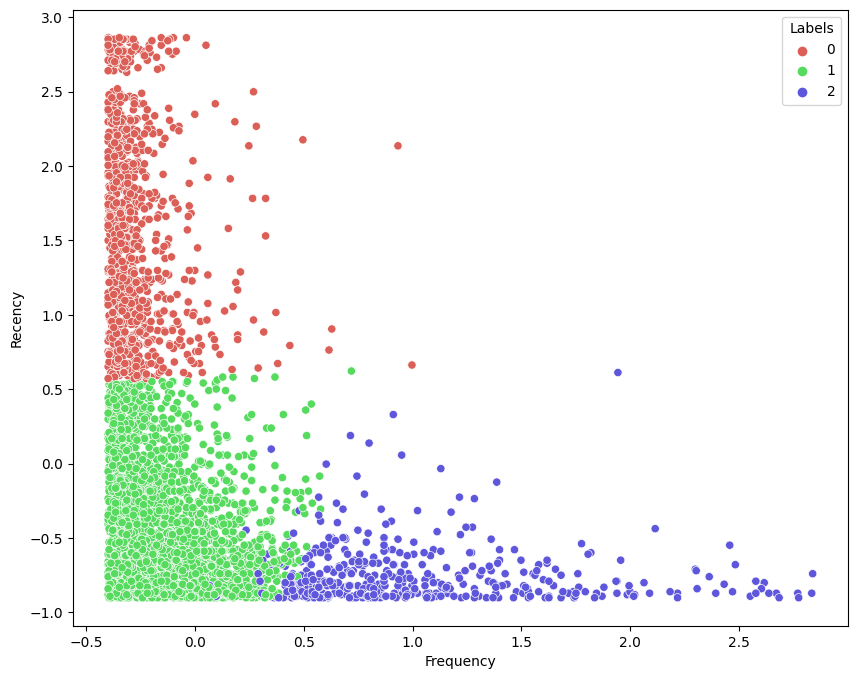

In [348]:
sns.scatterplot(x=df2['Frequency'], y=df2['Recency'], hue=df2['Labels'], palette=sns.color_palette('hls', n_colors=n_clust))

<Axes: xlabel='Amount', ylabel='Frequency'>

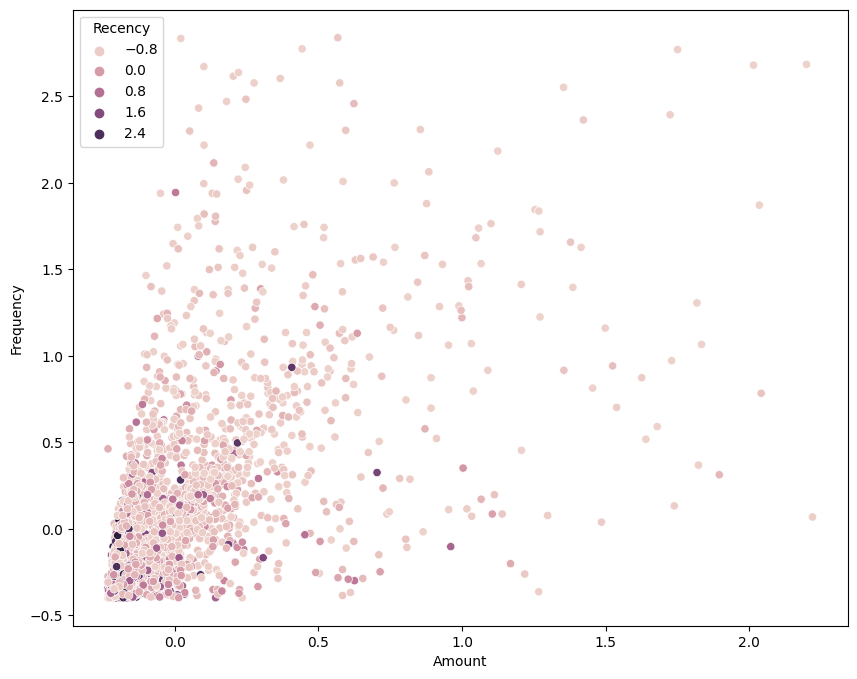

In [349]:
sns.scatterplot(x=df2['Amount'] ,y=df2['Frequency'], hue = df2['Recency'])

Text(0.5, 0, 'Total Belanja')

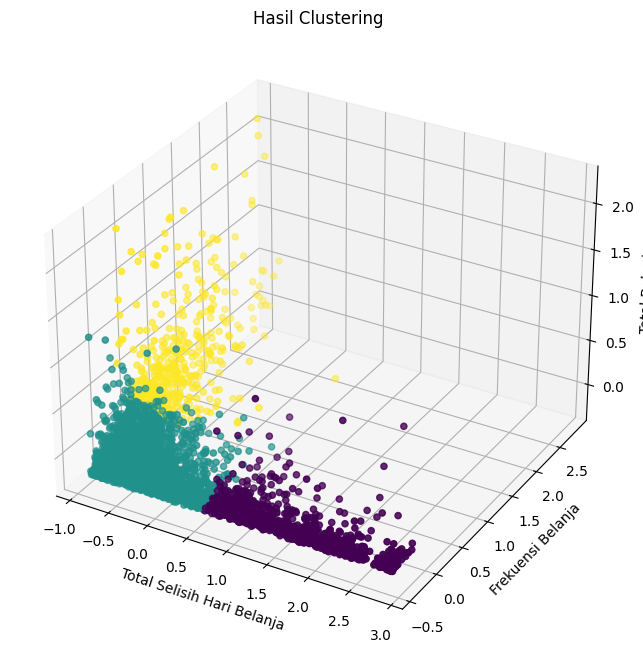

In [350]:
# Create 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=df2['Recency'], ys=df2['Frequency'], zs=df2['Amount'], c=df2['Labels'])

plt.title('Hasil Clustering')
ax.set_xlabel('Total Selisih Hari Belanja')
ax.set_ylabel('Frekuensi Belanja')
ax.set_zlabel('Total Belanja')

# Analisis Kualitatif Hasil Clustering
Grafik sebaran 3D ini dengan jelas menunjukkan bahwa algoritme pengelompokan K-Means kami telah berhasil mengelompokkan semua pelanggan ke dalam tiga kategori yang berbeda:

**Kategori 1:**

Warna: hijau

Jumlah: cukup banyak

Frekuensi pembelian: rendah

Jumlah pengeluaran: rendah

Kemutakhiran: bervariasi

**Kategori 2:**

Warna: ungu

Jumlah: banyak

Frekuensi pembelian: rendah hingga menengah

Jumlah pengeluaran: rendah hingga menengah

Kemutakhiran: rendah

**Kategori 3:**

Warna: kuning

Jumlah: sedikit

Frekuensi pembelian: bervariasi

Jumlah pengeluaran: tinggi

Kemutakhiran: rendah

# SAVE MODEL

In [295]:
df2.to_excel('output_cluster.xlsx')

In [296]:
df2.head()

,Recency,Frequency,Amount,Labels
0,-0.891260,0.376466,0.288849,2
1,-0.154795,-0.269954,-0.015280,1
2,-0.719755,-0.090155,-0.020084,1
3,2.216019,-0.329887,-0.192332,0
4,-0.548249,0.004025,-0.045760,1


note:

df = original dataset

df2 = processed dataset (include labels)

df2_unscaled = processed not scale

In [300]:
df1 = df2.drop(['Labels'],axis=1)

In [301]:
df1.head()

,Recency,Frequency,Amount
0,-0.891260,0.376466,0.288849
1,-0.154795,-0.269954,-0.015280
2,-0.719755,-0.090155,-0.020084
3,2.216019,-0.329887,-0.192332
4,-0.548249,0.004025,-0.045760


In [303]:
df1.to_excel('dataset_processed.xlsx')

In [297]:
df2_unscaled.head(3)

,Recency,Frequency,Amount
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55


In [299]:
df2_unscaled.to_excel('processed_not_scale.xlsx')